In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

In [2]:
data_folder = "data"
filename = "train.csv"
df = pd.read_csv(os.path.join("..", data_folder, filename), parse_dates=True, index_col="date")

In [3]:
df.head()

,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
date,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
2020-12-06,Prague_1,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2020-12-07,Prague_1,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
2020-12-08,Prague_1,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
2020-12-09,Prague_1,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


In [4]:
df.shape

(7340, 17)

In [5]:
df_subset = df[["orders", "warehouse", "holiday_name", "holiday", "shops_closed", "winter_school_holidays", "school_holidays", "id"]]

In [6]:
df_subset["warehouse"].unique()

array(['Prague_1', 'Brno_1', 'Prague_2', 'Prague_3', 'Munich_1',
       'Frankfurt_1', 'Budapest_1'], dtype=object)

### Routine check for missing dates

In [7]:
Prague_1_test = df_subset[df_subset["warehouse"] == "Prague_1"]

date_range = pd.date_range(start=Prague_1_test.index.min(), end=Prague_1_test.index.max(), freq='D')
# Check for missing dates
print(len(date_range) - len(Prague_1_test))

4


<AxesSubplot:xlabel='date'>

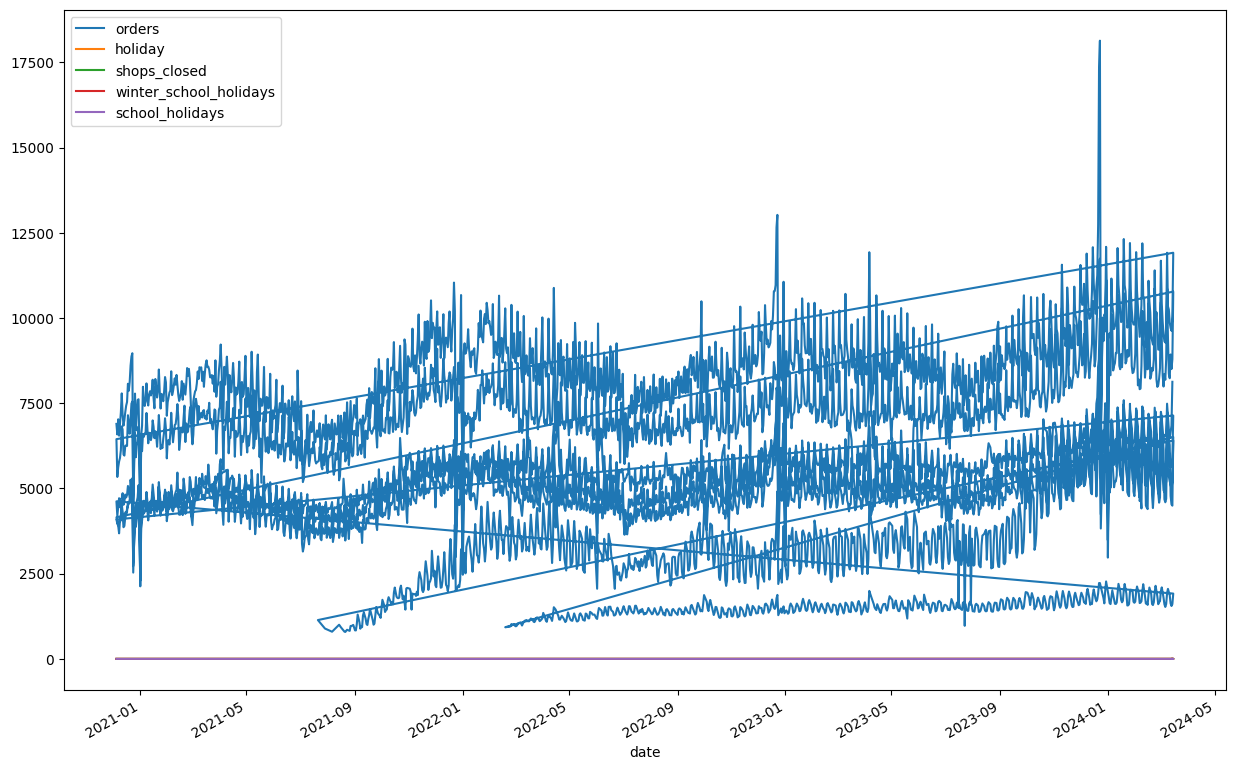

In [67]:
df_subset.plot(figsize=(15, 10))

### I will first try to treat the location as feature and not seperate each location

In [68]:
df_subset.isnull().sum()

orders                       0
warehouse                    0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64

In [69]:
# Investigate holiday_name column
df_subset["holiday_name"].unique()

array([nan, 'Christmas Eve', '2nd Christmas Day', 'New Years Day',
       'International womens day', 'Good Friday', 'Easter Monday',
       'Labour Day', 'Den osvobozeni', 'Cyrila a Metodej', 'Jan Hus',
       'Den ceske statnosti',
       'Den vzniku samostatneho ceskoslovenskeho statu',
       'Den boje za svobodu a demokracii', 'Peace Festival in Augsburg',
       'Reformation Day', 'Memorial Day of the Republic',
       'Memorial Day for the Victims of the Communist Dictatorships',
       'Memorial Day for the Victims of the Holocaust',
       'National Defense Day', 'Day of National Unity',
       'Independent Hungary Day', 'Memorial Day for the Martyrs of Arad',
       '1848 Revolution Memorial Day (Extra holiday)',
       "All Saints' Day Holiday"], dtype=object)

In [70]:
# I decide to use this as a feature, so i impute the nan with 0
df_imputed = df_subset.fillna(0)

In [71]:
df_imputed.isnull().sum()

orders                    0
warehouse                 0
holiday_name              0
holiday                   0
shops_closed              0
winter_school_holidays    0
school_holidays           0
id                        0
dtype: int64

<AxesSubplot:xlabel='date', ylabel='orders'>

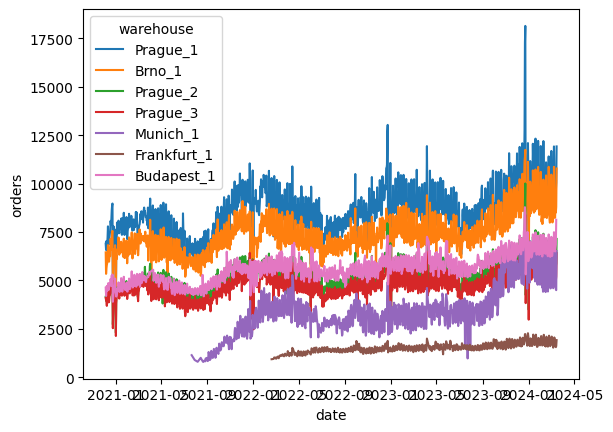

In [72]:
sns.lineplot(data=df_imputed, x="date", y="orders", hue="warehouse" )

### There would be the following possibilities to work on the problem further:
* Separate models for each location
* Global model with location as a feature
* Hierarchical model (both cross-location and location-specific patterns)
* Transfer Learning
* Clustering of locations (clustering and training model for each group)

In [73]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7340 entries, 2020-12-05 to 2024-03-14
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   orders                  7340 non-null   float64
 1   warehouse               7340 non-null   object 
 2   holiday_name            7340 non-null   object 
 3   holiday                 7340 non-null   int64  
 4   shops_closed            7340 non-null   int64  
 5   winter_school_holidays  7340 non-null   int64  
 6   school_holidays         7340 non-null   int64  
 7   id                      7340 non-null   object 
dtypes: float64(1), int64(4), object(3)
memory usage: 516.1+ KB


### Overall statistics

In [74]:
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
orders,7340.0,5535.443869,2182.680279,790.0,4434.0,5370.0,7009.25,18139.0
holiday,7340.0,0.027248,0.162816,0.0,0.0,0.0,0.00,1.0
shops_closed,7340.0,0.010899,0.103836,0.0,0.0,0.0,0.00,1.0
winter_school_holidays,7340.0,0.029973,0.170524,0.0,0.0,0.0,0.00,1.0
school_holidays,7340.0,0.007084,0.083876,0.0,0.0,0.0,0.00,1.0


### Statistics for each warehouse

In [75]:
warehouses = df_imputed["warehouse"].unique().tolist()

In [76]:
statistics_for_each_warehouse = pd.DataFrame()
for warehouse in warehouses:
    to_be_printed = df_imputed[df_imputed["warehouse"] == warehouse]
    statistics_for_each_warehouse = pd.concat([statistics_for_each_warehouse, to_be_printed[["orders"]].describe().T])
statistics_for_each_warehouse.index = warehouses
print(statistics_for_each_warehouse)

              count         mean          std     min     25%     50%  \
Prague_1     1193.0  8535.336966  1215.982528  3754.0  7812.0  8462.0   
Brno_1       1193.0  7274.532272   962.283379  4203.0  6685.0  7124.0   
Prague_2     1193.0  5142.093043   693.820944  2295.0  4678.0  5070.0   
Prague_3     1193.0  4705.911148   607.034011  2129.0  4357.0  4681.0   
Munich_1      785.0  3396.092994  1294.250128   790.0  2645.0  3194.0   
Frankfurt_1   629.0  1499.068362   232.918694   929.0  1354.0  1480.0   
Budapest_1   1154.0  5555.864818   688.113844  3897.0  5121.5  5540.5   

                 75%      max  
Prague_1     9174.00  18139.0  
Brno_1       7745.00  11741.0  
Prague_2     5515.00  10004.0  
Prague_3     5015.00   8387.0  
Munich_1     3890.00   7498.0  
Frankfurt_1  1627.00   2272.0  
Budapest_1   5929.25   8779.0  


<AxesSubplot:>

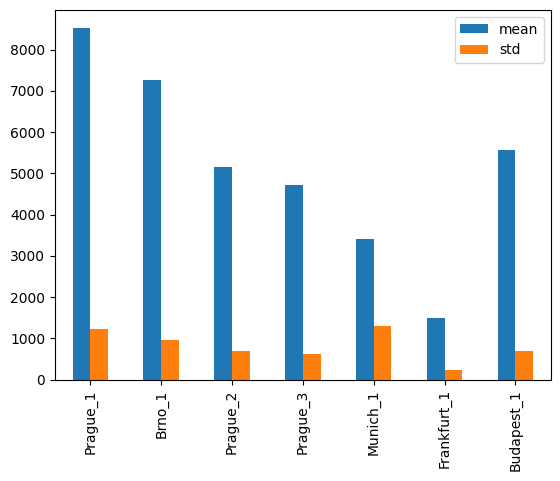

In [77]:
statistics_for_each_warehouse[["mean","std"]].plot(kind="bar")

## Preperation of Data for Machine Learning

### Convert Date into Timesteps

In [78]:
unique_timestamps = df_imputed.index.unique().sort_values().tolist()

In [79]:
mapping_dict = {}
for idx, key in enumerate(unique_timestamps):
    mapping_dict[key] = idx

In [80]:
df_with_timesteps = df_imputed.reset_index()

df_with_timesteps["date"] = df_with_timesteps["date"].map(mapping_dict)
df_with_timesteps

,date,orders,warehouse,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,0,6895.0,Prague_1,0,0,0,0,0,Prague_1_2020-12-05
1,1,6584.0,Prague_1,0,0,0,0,0,Prague_1_2020-12-06
2,2,7030.0,Prague_1,0,0,0,0,0,Prague_1_2020-12-07
3,3,6550.0,Prague_1,0,0,0,0,0,Prague_1_2020-12-08
4,4,6910.0,Prague_1,0,0,0,0,0,Prague_1_2020-12-09
...,...,...,...,...,...,...,...,...,...
7335,1187,6733.0,Budapest_1,0,0,0,0,0,Budapest_1_2024-03-10
7336,1188,6492.0,Budapest_1,0,0,0,0,0,Budapest_1_2024-03-11
7337,1189,6661.0,Budapest_1,0,0,0,0,0,Budapest_1_2024-03-12
7338,1190,6843.0,Budapest_1,0,0,0,0,0,Budapest_1_2024-03-13


In [81]:
# I decided to cut off the id column
df_with_timesteps = df_with_timesteps.drop(columns=["id"])
df_with_timesteps

,date,orders,warehouse,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
0,0,6895.0,Prague_1,0,0,0,0,0
1,1,6584.0,Prague_1,0,0,0,0,0
2,2,7030.0,Prague_1,0,0,0,0,0
3,3,6550.0,Prague_1,0,0,0,0,0
4,4,6910.0,Prague_1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
7335,1187,6733.0,Budapest_1,0,0,0,0,0
7336,1188,6492.0,Budapest_1,0,0,0,0,0
7337,1189,6661.0,Budapest_1,0,0,0,0,0
7338,1190,6843.0,Budapest_1,0,0,0,0,0


### Preprocess warehouse and holiday_name column using OHE